# _(Brunel & Hakim, 1999)_ Fast Global Oscillation

Implementation of the paper:

- Brunel, Nicolas, and Vincent Hakim. "Fast global oscillations in networks of integrate-and-fire neurons with low firing rates." Neural computation 11.7 (1999): 1621-1671.

In [1]:
import brainpy as bp
import numpy as np

bp.backend.set('numba')

In [2]:
Vr = 10.  # mV
theta = 20.  # mV
tau = 20.  # ms
delta = 2.  # ms
taurefr = 2.  # ms
duration = 100.  # ms
J = .1  # mV
muext = 25.  # mV
sigmaext = 1.  # mV
C = 1000
N = 5000
sparseness = float(C) / N

In [3]:
class LIF(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    def __init__(self, size, **kwargs):
        def f_v(V, t):
            return (-V + muext) / tau

        def g_v(V, t):
            return sigmaext / np.sqrt(tau)

        self.int_v = bp.sdeint(f=f_v, g=g_v)

        self.spike = bp.ops.zeros(size, dtype=bool)
        self.not_ref = bp.ops.ones(size, dtype=bool)
        self.V = bp.ops.ones(size) * Vr
        self.t_last_spike = -1e7 * bp.ops.ones(size)

        super(LIF, self).__init__(size, **kwargs)

    def update(self, _t):
        for i in range(self.num):
            self.spike[i] = False
            self.not_ref[i] = False
            if (_t - self.t_last_spike[i]) > taurefr:
                V = self.int_v(self.V[i], _t)
                if V > theta:
                    self.spike[i] = True
                    self.V[i] = Vr
                    self.t_last_spike[i] = _t
                else:
                    self.V[i] = V
                    self.not_ref[i] = True

In [4]:
class Syn(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, conn, delay, **kwargs):
        self.conn = conn(pre.size, post.size)
        self.pre2post = self.conn.requires('pre2post')
        self.g = self.register_constant_delay('g', post.num, delay_time=delay)
        super(Syn, self).__init__(pre, post, **kwargs)

    def update(self, _t):
        s = bp.ops.zeros(self.post.num)
        for pre_i, spike in enumerate(self.pre.spike):
            if spike:
                for post_i in self.pre2post[pre_i]:
                    s[post_i] += J
        self.g.push(s)
        self.post.V -= self.g.pull() * self.post.not_ref

In [5]:
group = LIF(N, monitors=['spike'])
conn = Syn(pre=group, post=group, conn=bp.connect.FixedProb(sparseness), delay=delta)
net = bp.Network(group, conn)
net.run(duration, report=True)

Compilation used 1.8973 s.
Start running ...
Run 10.0% used 0.186 s.
Run 20.0% used 0.366 s.
Run 30.0% used 0.542 s.
Run 40.0% used 0.728 s.
Run 50.0% used 0.912 s.
Run 60.0% used 1.091 s.
Run 70.0% used 1.262 s.
Run 80.0% used 1.427 s.
Run 90.0% used 1.626 s.
Run 100.0% used 1.805 s.
Simulation is done in 1.805 s.



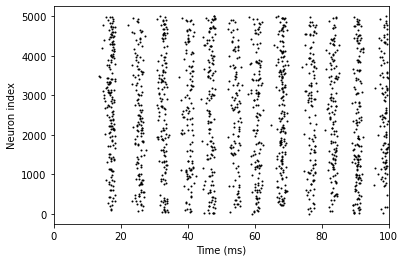

In [6]:
bp.visualize.raster_plot(net.ts, group.mon.spike, xlim=(0, duration), show=True)